In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint
from rouge import Rouge


from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Concatenate
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy, KLDivergence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

import matplotlib.pyplot as plt 
from keras.regularizers import l2
import os

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',', nrows=90000)

In [3]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


In [4]:
df['headline'] = df['headline'].apply(lambda x : '_SOS_ '+ x + ' _EOS_')

In [5]:
df.head()

,headline,text
0,_SOS_ keep related supplies in the same area m...,photographer keep necessary lens cord battery ...
1,_SOS_ create a sketch in the neopoprealist man...,see image draw develops stepbystep however imp...
2,_SOS_ get a bachelors degree enroll in a studi...,possible become vfx artist without college deg...
3,_SOS_ start with some experience or interest i...,best art investor research piece art buy someo...
4,_SOS_ keep your reference materials sketches a...,start planning project work shall likely gathe...


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [8]:
train, val = train_test_split(train, test_size=0.056, random_state=42, shuffle=True)

In [9]:
train.shape

(78780, 2)

In [10]:
test.shape

(4393, 2)

In [11]:
val.shape

(4674, 2)

In [12]:
max_len_text = 150 
max_len_summary = 35

In [13]:
X_train = train['text'].astype(str).values.tolist()
X_test = test['text'].astype(str).values.tolist()
X_val = val['text'].astype(str).values.tolist()

Y_train = train['headline'].astype(str).values.tolist()
Y_test = test['headline'].astype(str).values.tolist()
Y_val = val['headline'].astype(str).values.tolist()

Keras padding https://keras.io/guides/understanding_masking_and_padding/

In [14]:
x_vocab = 15054

x_tokenizer = Tokenizer(num_words=x_vocab)
x_tokenizer.fit_on_texts(X_train)

x_train = x_tokenizer.texts_to_sequences(X_train)
x_val = x_tokenizer.texts_to_sequences(X_val)
x_test = x_tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train, maxlen=max_len_text, padding="post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding="post")
x_test = pad_sequences(x_test, maxlen=max_len_text, padding="post")

y_vocab = 5305

y_tokenizer = Tokenizer(num_words=y_vocab)
y_tokenizer.fit_on_texts(Y_train)

y_train= y_tokenizer.texts_to_sequences(Y_train)
y_val = y_tokenizer.texts_to_sequences(Y_val)
y_test = y_tokenizer.texts_to_sequences(Y_test)

y_train = pad_sequences(y_train, maxlen=max_len_summary, padding="post")
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding="post")
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding="post")

In [15]:
y_vocab

5305

In [16]:
x_vocab

15054

In [17]:
batch_size = 512
epochs = 10
latent_dim = 400
embedding_dim = 100

In [18]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [202]:
model = load_model("seq2seq_90000.h5")

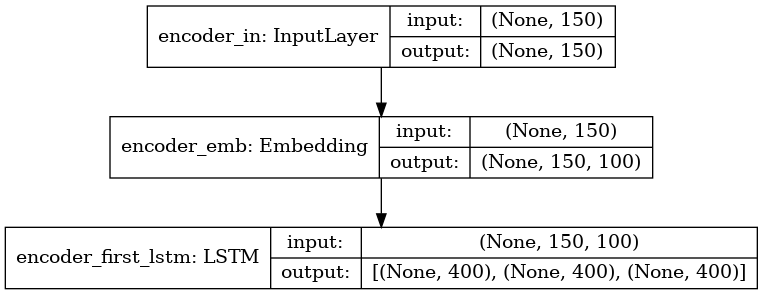

In [203]:
# encoder inference
encoder_inputs = model.input[0]

encoder_embedding_layer = model.layers[2]
encoder_embedding = encoder_embedding_layer(encoder_inputs)

encoder_outputs, state_h_enc, state_c_enc = model.layers[4](encoder_embedding) #last lstm layer
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

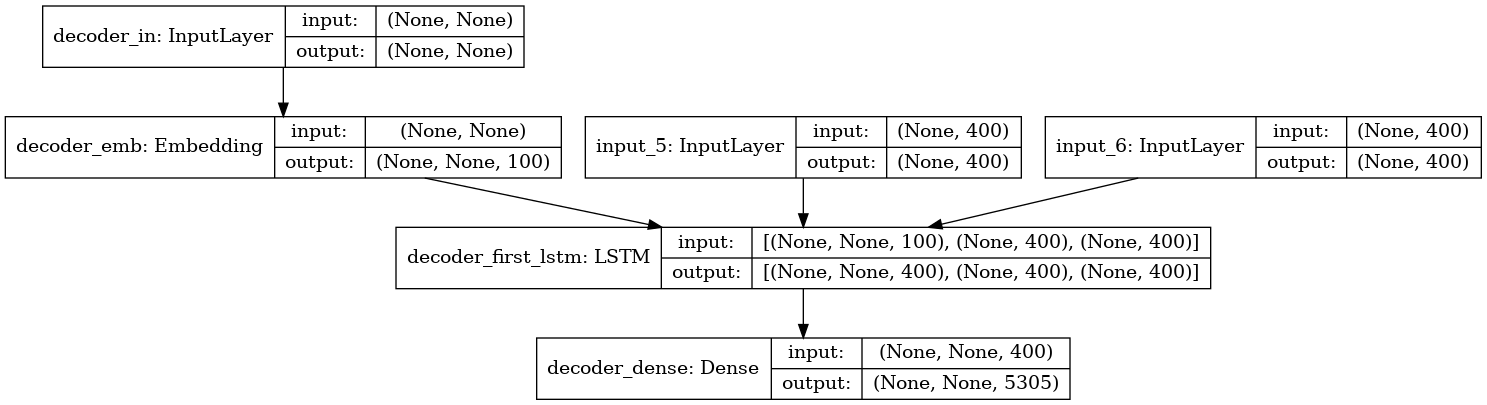

In [204]:
# decoder inference
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_layer = model.layers[3]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [50]:
def n_max_elements(data, n):
    elems = []
    indexs = []
  
    for i in range(0, n): 
        max_ = 0
        index = 0
          
        for j in range(len(data)):     
            if data[j] > max_ and data[j] not in elems:
                max_ = data[j];
                index = j
                  
        elems.append(max_)
        indexs.append(index)
          
    return elems, indexs

In [51]:
def close_to_num(data, num):
    elem = 0
    index = 0
 
    for j in range(len(data)):     
        if data[j] > elem and data[j] < num:
            elem = data[j];
            index = j
          
    return elem, index

In [52]:
def top_k_sampling(data, k):
    pred = data[0]
    top_k_prob, top_k_index = n_max_elements(pred, k)
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [53]:
def nucleus_sampling(data, p):
    pred = data[0]
    sum_ = 0
    top_k_prob = []
    top_k_index = []
    prob = 1
    while sum_ <= p:
        prob, index = close_to_num(pred, prob)
        top_k_prob.append(prob)
        top_k_index.append(index)
        sum_ += prob
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [54]:
def beam_search_decoder(data, k=1):
    sequences = [[list(), 0.0]]
    
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [241]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :] )   
        sampled_token_index = top_k_sampling(output_tokens[0, -1:], 30)
#         sampled_token_index = nucleus_sampling(output_tokens[0, -1:], 0.25)
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eos':
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eos' or len(decoded_sentence.split()) > max_len_summary:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        states_value = [h, c]

    return decoded_sentence

In [190]:
def decode_sequence_b(input_seq, w):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    sent = ''
    decoded_sentence = [''] * w
    while not stop_condition:
        for j in range(w):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
            # Sample a token
            sampled_token_index = beam_search_decoder(output_tokens[0, -1:], w)
            for i in range(w):
                if sampled_token_index[i][0][0] != 0:
                    sampled_token = reverse_target_word_index[sampled_token_index[i][0][0]]
                else:
                    sampled_token == 'eos'
                if sampled_token != 'eos':
                    decoded_sentence[i] += ' ' + sampled_token

                    # Exit condition: either hit max length or find stop word.
                if sampled_token == 'eos' or len(decoded_sentence[i].split()) > max_len_summary:
                    stop_condition = True
                    sent = decoded_sentence[i]

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index[j][0][0]

            # Update internal states
            states_value = [h, c]

    return sent

In [56]:
def seq2summary(input_seq):
    summary=''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sos']) and i != target_word_index['eos']:
            summary += reverse_target_word_index[i]+' '           
    return summary

def seq2text(input_seq):
    return x_tokenizer.sequences_to_texts([input_seq])[0]

In [244]:
for i in range(1):
    print("Review:", seq2text(x_test[i]))
    print("\nOriginal summary:", seq2summary(y_test[i]))
    print("\nPredicted summary:", decode_sequence(x_test[i].reshape(1, max_len_text)))
    print("\n\n")

Review: people fill one stuff sack food go eat trail another one toiletry could use stuff sack pack nearly anything season hiker bother put clothing stuff sack since pack softer flexible item around heavier awkward item efficient use space bear canister container use store food deodorant sunscreen item attract bear mandatory use certain area high concentration bear hike place require use bear canister important pack canister efficiently become item pack use item like clothes fill void bear canister might use example rain clothes pack cover fill space anything go wear camp want bear attract smell tent like clothes soak food scent entire day canister likely heavy pack heavy item shoulder blade right next spine pack flexible item like tarp extra clothing around canister move walk convenient lightweight item could save backpack get soak rain snow cover attach backpack inclement weather rain snow small light enough stuff top pack easily access need

Original summary: necessary supplies lay 